In [1]:
# import libraries for working with .nc
import xarray as xr
import os   
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd


load one year
(binned dataset as an example)

In [2]:
# load /mnt/d/Dropbox/R_projects/SV_phenology/test_chl3days.nc as xarray
ds = xr.open_dataset('/mnt/d/Dropbox/R_projects/SV_phenology/test_chl3days.nc')


In [3]:
ds

<xarray.Dataset>
Dimensions:    (time: 62, latitude: 1248, longitude: 1056, time2: 62)
Coordinates:
  * latitude   (latitude) float64 84.99 84.98 84.97 84.96 ... 72.03 72.02 72.01
  * longitude  (longitude) float64 -4.995 -4.943 -4.891 ... 49.85 49.9 49.95
  * time       (time) datetime64[ns] 2010-03-21 2010-03-24 ... 2010-09-20
  * time2      (time2) timedelta64[ns] 14689 days 14692 days ... 14872 days
Data variables:
    CHL        (time, latitude, longitude) float32 ...
    mask       (latitude, longitude) float64 ...

In [20]:
lons = ds.longitude.values
lats = ds.latitude.values


#create a dataset with the coordinates of 10 randomly selected points
# set seed for reproducibility
np.random.seed(447)

pt = pd.DataFrame({
    'id': np.arange(1, 11),
    'longitude': np.random.choice(lons, 10),
    'latitude': np.random.choice(lats, 10)
})

pt

,id,longitude,latitude
0,1,13.390625,72.421875
1,2,22.296875,75.619792
2,3,7.088542,78.359375
3,4,13.755208,81.921875
4,5,38.442708,74.213542
5,6,19.744792,76.505208
6,7,38.026042,82.182292
7,8,40.942708,83.963542
8,9,18.338542,80.286458
9,10,32.557292,79.130208


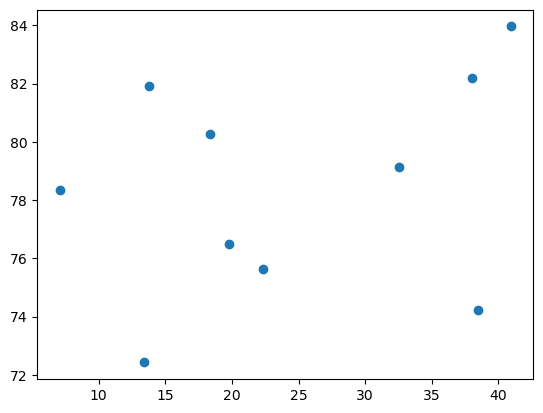

In [21]:
# plot pt on a map
plt.scatter(pt.longitude, pt.latitude)

In [37]:
import random

# Get the size of each dimension in ds
size_lat = ds.latitude.size
size_lon = ds.longitude.size
size_time = ds.time.size

# Randomly select 10 indices along each dimension
idx_lat = [random.randint(0, size_lat-1) for i in range(10)]
idx_lon = [random.randint(0, size_lon-1) for i in range(10)]


# Select the subset of data for the 10 random indices
pt = ds.isel(latitude=idx_lat, longitude=idx_lon)


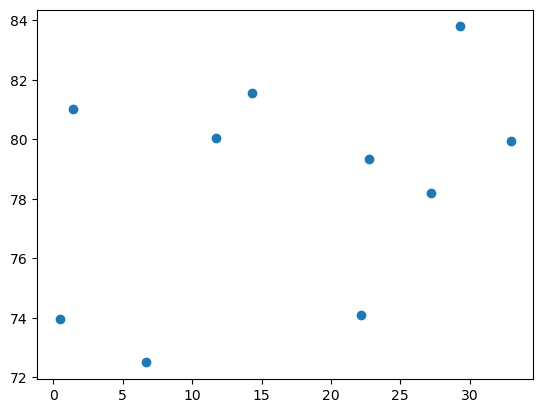

In [35]:
# plot pt
plt.scatter(pt.longitude, pt.latitude)

In [38]:
pt

<xarray.Dataset>
Dimensions:    (time: 62, latitude: 10, longitude: 10, time2: 62)
Coordinates:
  * latitude   (latitude) float64 79.04 84.79 83.2 72.84 ... 78.44 81.46 81.86
  * longitude  (longitude) float64 21.26 43.91 37.35 ... 10.37 17.97 26.67
  * time       (time) datetime64[ns] 2010-03-21 2010-03-24 ... 2010-09-20
  * time2      (time2) timedelta64[ns] 14689 days 14692 days ... 14872 days
Data variables:
    CHL        (time, latitude, longitude) float32 ...
    mask       (latitude, longitude) float64 ...

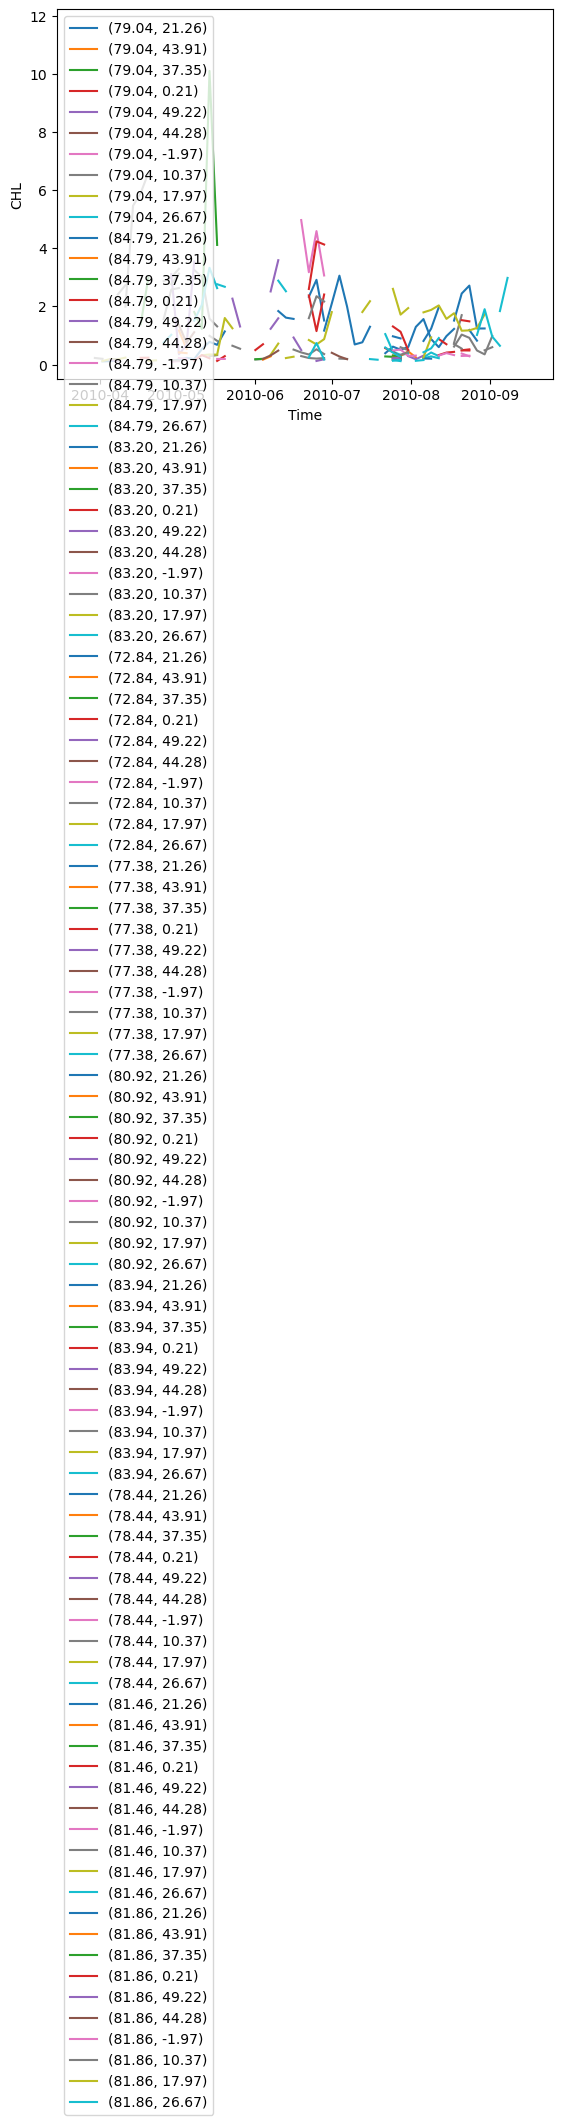

In [41]:
# Loop over the latitude and longitude indices of pt and plot the CHL time series
for i in range(pt.latitude.size):
    for j in range(pt.longitude.size):
        chl = pt['CHL'][:, i, j]
        plt.plot(chl.time, chl.values, label=f"({pt.latitude[i].values:.2f}, {pt.longitude[j].values:.2f})")

# Add labels and legend
plt.xlabel('Time')
plt.ylabel('CHL')
plt.legend()

# Show the plot
plt.show()


In [42]:
# I want to save a csv of pt
#pt.to_dataframe().to_csv('pt.csv')

ora provo con i dati giornalieri

Load a dataset

In [45]:
# print current working directory
print(os.getcwd())
# Define the path to the directory containing the data
data_dir = '/mnt/d/Dropbox/R_projects/SV_phenology/data/daily_coarsened'


/mnt/d/Dropbox/R_projects/SV_phenology/R


In [47]:
# crei es data data_dir, 1998 il primo file
es = xr.open_mfdataset(os.path.join(data_dir, '1998','*.nc'), combine='by_coords')


In [54]:

# Define the latitude and longitude of the grid points
lats = es.latitude.values
lons = es.longitude.values

# Sample 10 random points from the grid
random.seed(447)
lat_idx = random.sample(range(len(lats)), 10)
lon_idx = random.sample(range(len(lons)), 10)
pt_lat = lats[lat_idx]
pt_lon = lons[lon_idx]

# Initialize an empty dataframe to hold the results
results = pd.DataFrame(columns=['id', 'longitude', 'latitude', 'time', 'CHL'])


In [55]:
pt_lon

array([25.99479167,  3.546875  , 48.234375  , 43.13020833, 15.00520833,
       -1.609375  , 12.19270833, 21.93229167, 20.16145833,  4.53645833])

In [57]:

# Loop over each year directory
for year_dir in os.listdir(data_dir):
    # Loop over each month file in the year directory
    #for month_file in os.listdir(os.path.join(data_dir, year_dir)):
    # Load the CHL data for the month file into an xarray dataset
    ds = xr.open_mfdataset(os.path.join(data_dir, year_dir,'*.nc'), combine='by_coords')

    # Select the 10 points from the grid
    pt = ds.isel(latitude=lat_idx, longitude=lon_idx)

    # Loop over each selected point
    for i in range(pt.latitude.size):
    # Extract the CHL values for the point and convert to a pandas dataframe
        chl_data = pt['CHL'][:, i].to_dataframe().reset_index()

        # Add columns for the ID, latitude, and longitude of the point
        chl_data['id'] = f"{pt_lat[i]:.2f},{pt_lon[i]:.2f}"
        chl_data['latitude'] = pt_lat[i]
        chl_data['longitude'] = pt_lon[i]

        # Append the CHL data for the point to the results dataframe
        results = pd.concat([results, chl_data], ignore_index=True)

# Sort the results dataframe by time
results = results.sort_values(by='time')

# Save the results to a CSV file
results.to_csv('/mnt/d/Dropbox/R_projects/SV_phenology/data/00.3.0.1_10points.csv', index=False)